**Keval Shah <br> 60009220061 <br> IPCV Lab7**

In [15]:
# import os

# dataset_path = "/kaggle/input/ade20k-dataset"

# # List a few sample files to confirm it's working
# for root, dirs, files in os.walk(dataset_path):
#     for file in files[:10]:
#         print(os.path.join(root, file))

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
import torch.amp as amp

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Check if GPU is available and how many
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_gpus = torch.cuda.device_count()
print(f"Using device: {device} with {num_gpus} GPUs")

# Enable cuDNN benchmarking for faster training
torch.backends.cudnn.benchmark = True

# Path configuration for Kaggle
WORKING_DIR = '/kaggle/working'

# Create plots directory
PLOTS_DIR = os.path.join(WORKING_DIR, 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

# Configuration
CONFIG = {
    'img_size': 256,  # U-Net works better with powers of 2
    'batch_size': 16 * max(1, num_gpus),  # Scale batch size with number of GPUs
    'num_epochs': 30,
    'learning_rate': 0.001,
    'num_classes': 150,  # ADE20K has 150 classes
    'save_path': os.path.join(WORKING_DIR, 'models'),
    'use_binary_loss': False  # Set to True for Binary Cross-Entropy, False for Categorical
}

os.makedirs(CONFIG['save_path'], exist_ok=True)

# Updated Dataset class for ADE20K with direct path handling
class ADE20KDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.transform = transform
        self.img_filenames = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_name = self.img_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load and preprocess image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # Resize to configured size
        image = image.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
        
        # Convert to numpy array
        image = np.array(image)
        mask = np.array(mask)
        
        # Ensure mask values are within valid range
        mask = np.clip(mask, 0, CONFIG['num_classes']-1)
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        else:
            # Normalize and convert to tensor
            image = image.transpose(2, 0, 1) / 255.0
            image = torch.FloatTensor(image)
        
        # Convert mask to tensor
        mask = torch.LongTensor(mask)
        
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with Kaggle paths
train_dataset = ADE20KDataset(
    image_dir='/kaggle/input/ade20k-dataset/ADEChallengeData2016/images/training',
    mask_dir='/kaggle/input/ade20k-dataset/ADEChallengeData2016/annotations/training',
    img_size=CONFIG['img_size'],
    transform=transform
)

val_dataset = ADE20KDataset(
    image_dir='/kaggle/input/ade20k-dataset/ADEChallengeData2016/images/validation',
    mask_dir='/kaggle/input/ade20k-dataset/ADEChallengeData2016/annotations/validation',
    img_size=CONFIG['img_size'],
    transform=transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Define U-Net model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Ensuring x1 size matches x2 size
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                         diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=150, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (downsampling)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Decoder (upsampling)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Final output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Final output
        logits = self.outc(x)
        return logits

# Initialize model
model = UNet(n_channels=3, n_classes=CONFIG['num_classes'], bilinear=True)
if num_gpus > 1:
    print(f"Using {num_gpus} GPUs with DataParallel")
    model = nn.DataParallel(model)
model = model.to(device)
print("Model initialized")

# Define loss function based on configuration
if CONFIG['use_binary_loss']:
    # For binary segmentation
    criterion = nn.BCEWithLogitsLoss()
else:
    # For multi-class segmentation
    criterion = nn.CrossEntropyLoss()

# Initialize optimizer with Adam
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=5, 
    verbose=True
)

# For mixed precision training
scaler = amp.GradScaler()

def calculate_iou(outputs, targets, num_classes):
    outputs = F.softmax(outputs, dim=1)
    predictions = torch.argmax(outputs, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        pred_mask = (predictions == cls).float()
        target_mask = (targets == cls).float()
        intersection = (pred_mask * target_mask).sum().item()
        union = pred_mask.sum().item() + target_mask.sum().item() - intersection
        if union > 0:
            iou = intersection / union
            iou_per_class.append(iou)
    return np.mean(iou_per_class) if iou_per_class else 0.0

def calculate_pixel_accuracy(outputs, targets):
    predictions = torch.argmax(outputs, dim=1)
    correct = (predictions == targets).float().sum().item()
    total = targets.numel()
    return correct / total

def visualize_predictions(model, dataloader, num_samples=3, scaler=None, epoch=None):
    model.eval()
    
    # Create color map for visualization
    def get_color_map(num_classes):
        color_map = np.zeros((num_classes, 3), dtype=np.uint8)
        for i in range(num_classes):
            r = np.random.randint(0, 256)
            g = np.random.randint(0, 256)
            b = np.random.randint(0, 256)
            color_map[i] = [r, g, b]
        return color_map
    
    color_map = get_color_map(CONFIG['num_classes'])
    
    # Get first batch from dataloader
    images, masks = next(iter(dataloader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples].to(device)
    
    # Generate predictions
    with torch.no_grad():
        with amp.autocast('cuda', enabled=scaler is not None):
            outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    # Create visualization figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Original image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth mask
        mask = masks[i].cpu().numpy()
        mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for j in range(CONFIG['num_classes']):
            mask_rgb[mask == j] = color_map[j]
        axes[i, 1].imshow(mask_rgb)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Predicted mask
        pred = predictions[i].cpu().numpy()
        pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        for j in range(CONFIG['num_classes']):
            pred_rgb[pred == j] = color_map[j]
        axes[i, 2].imshow(pred_rgb)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    
    # Save figure
    if epoch is not None:
        filename = os.path.join(PLOTS_DIR, f'predictions_epoch_{epoch}.png')
    else:
        filename = os.path.join(PLOTS_DIR, 'predictions_initial.png')
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved visualization to {filename}")

def train_one_epoch(model, dataloader, criterion, optimizer, scaler):
    model.train()
    epoch_loss, epoch_iou, epoch_accuracy = 0.0, 0.0, 0.0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for images, masks in progress_bar:
        # Move data to device
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        # Forward pass with mixed precision
        with amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Backward pass with optimizer step
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calculate metrics
        with torch.no_grad():
            iou = calculate_iou(outputs, masks, CONFIG['num_classes'])
            accuracy = calculate_pixel_accuracy(outputs, masks)
        
        # Update running totals
        epoch_loss += loss.item()
        epoch_iou += iou
        epoch_accuracy += accuracy
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'IoU': f"{iou:.4f}",
            'Acc': f"{accuracy:.4f}"
        })
    
    # Calculate epoch averages
    epoch_loss /= len(dataloader)
    epoch_iou /= len(dataloader)
    epoch_accuracy /= len(dataloader)
    
    return epoch_loss, epoch_iou, epoch_accuracy

def validate(model, dataloader, criterion, scaler):
    model.eval()
    val_loss, val_iou, val_accuracy = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")
        for images, masks in progress_bar:
            # Move data to device
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            # Forward pass with mixed precision
            with amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            # Calculate metrics
            iou = calculate_iou(outputs, masks, CONFIG['num_classes'])
            accuracy = calculate_pixel_accuracy(outputs, masks)
            
            # Update running totals
            val_loss += loss.item()
            val_iou += iou
            val_accuracy += accuracy
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'IoU': f"{iou:.4f}",
                'Acc': f"{accuracy:.4f}"
            })
    
    # Calculate epoch averages
    val_loss /= len(dataloader)
    val_iou /= len(dataloader)
    val_accuracy /= len(dataloader)
    
    return val_loss, val_iou, val_accuracy

# Visualize initial predictions before training
print("Predictions before training:")
visualize_predictions(model, val_loader, num_samples=3, scaler=scaler)

# Training loop
best_val_iou = 0.0
train_losses, train_ious, train_accs = [], [], []
val_losses, val_ious, val_accs = [], [], []

start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    
    # Train for one epoch
    train_loss, train_iou, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_iou, val_acc = validate(model, val_loader, criterion, scaler)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_accs.append(val_acc)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Acc: {val_acc:.4f}")
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), os.path.join(CONFIG['save_path'], 'best_model.pth'))
        else:
            torch.save(model.state_dict(), os.path.join(CONFIG['save_path'], 'best_model.pth'))
        print(f"New best model with IoU: {val_iou:.4f}")
    
    # Visualize predictions periodically
    if (epoch + 1) % 5 == 0 or epoch == CONFIG['num_epochs'] - 1:
        print(f"Visualizing predictions after epoch {epoch+1}:")
        visualize_predictions(model, val_loader, num_samples=3, scaler=scaler, epoch=epoch+1)

# Print training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# IoU plot
plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Training and Validation IoU')

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'training_history.png'), dpi=200, bbox_inches='tight')
plt.close()
print(f"Saved training history plot to {os.path.join(PLOTS_DIR, 'training_history.png')}")

# Final evaluation with best model
best_model_path = os.path.join(CONFIG['save_path'], 'best_model.pth')
if os.path.exists(best_model_path):
    # Load best model
    model_for_eval = UNet(n_channels=3, n_classes=CONFIG['num_classes'], bilinear=True).to(device)
    model_for_eval.load_state_dict(torch.load(best_model_path))
    if num_gpus > 1:
        model_for_eval = nn.DataParallel(model_for_eval)
    
    print("Loaded best model for final evaluation")
    
    # Final validation
    final_val_loss, final_val_iou, final_val_acc = validate(model_for_eval, val_loader, criterion, scaler)
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Final Validation IoU: {final_val_iou:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    
    # Visualize final predictions
    print("Final predictions:")
    visualize_predictions(model_for_eval, val_loader, num_samples=5, scaler=scaler, epoch='final')

Using device: cuda with 1 GPUs
Training dataset size: 20210
Validation dataset size: 2000
Model initialized
Predictions before training:
Saved visualization to /kaggle/working/plots/predictions_initial.png

Epoch 1/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=2.4289, IoU=0.0600, Acc=0.3901]


Train Loss: 2.6840, Train IoU: 0.0467, Train Acc: 0.3656
Val Loss: 2.3676, Val IoU: 0.0610, Val Acc: 0.4193
New best model with IoU: 0.0610

Epoch 2/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=2.1622, IoU=0.0752, Acc=0.4366]


Train Loss: 2.2835, Train IoU: 0.0700, Train Acc: 0.4315
Val Loss: 2.1216, Val IoU: 0.0766, Val Acc: 0.4630
New best model with IoU: 0.0766

Epoch 3/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=2.0195, IoU=0.0830, Acc=0.4909]


Train Loss: 2.1241, Train IoU: 0.0833, Train Acc: 0.4635
Val Loss: 2.0317, Val IoU: 0.0862, Val Acc: 0.4805
New best model with IoU: 0.0862

Epoch 4/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.9390, IoU=0.0951, Acc=0.5157]


Train Loss: 2.0155, Train IoU: 0.0929, Train Acc: 0.4865
Val Loss: 1.9419, Val IoU: 0.0975, Val Acc: 0.5008
New best model with IoU: 0.0975

Epoch 5/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.8663, IoU=0.0957, Acc=0.5381]


Train Loss: 1.9337, Train IoU: 0.0994, Train Acc: 0.5040
Val Loss: 1.8538, Val IoU: 0.0976, Val Acc: 0.5216
New best model with IoU: 0.0976
Visualizing predictions after epoch 5:
Saved visualization to /kaggle/working/plots/predictions_epoch_5.png

Epoch 6/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.7837, IoU=0.0962, Acc=0.5341]


Train Loss: 1.8677, Train IoU: 0.1053, Train Acc: 0.5180
Val Loss: 1.8364, Val IoU: 0.1054, Val Acc: 0.5241
New best model with IoU: 0.1054

Epoch 7/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=1.7387, IoU=0.1104, Acc=0.5685]


Train Loss: 1.8147, Train IoU: 0.1086, Train Acc: 0.5292
Val Loss: 1.7464, Val IoU: 0.1081, Val Acc: 0.5447
New best model with IoU: 0.1081

Epoch 8/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=1.8499, IoU=0.1000, Acc=0.5295]


Train Loss: 1.7725, Train IoU: 0.1129, Train Acc: 0.5381
Val Loss: 1.8325, Val IoU: 0.1068, Val Acc: 0.5199

Epoch 9/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s, loss=1.8643, IoU=0.0977, Acc=0.5414]


Train Loss: 1.7353, Train IoU: 0.1159, Train Acc: 0.5463
Val Loss: 1.7938, Val IoU: 0.1080, Val Acc: 0.5384

Epoch 10/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.7283, IoU=0.1065, Acc=0.5672]


Train Loss: 1.7087, Train IoU: 0.1185, Train Acc: 0.5517
Val Loss: 1.6930, Val IoU: 0.1227, Val Acc: 0.5588
New best model with IoU: 0.1227
Visualizing predictions after epoch 10:
Saved visualization to /kaggle/working/plots/predictions_epoch_10.png

Epoch 11/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.8168, IoU=0.1030, Acc=0.5470]


Train Loss: 1.6792, Train IoU: 0.1212, Train Acc: 0.5574
Val Loss: 1.7625, Val IoU: 0.1146, Val Acc: 0.5448

Epoch 12/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.7991, IoU=0.1133, Acc=0.5459]


Train Loss: 1.6539, Train IoU: 0.1239, Train Acc: 0.5629
Val Loss: 1.6808, Val IoU: 0.1199, Val Acc: 0.5563

Epoch 13/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s, loss=1.7068, IoU=0.1039, Acc=0.5600]


Train Loss: 1.6400, Train IoU: 0.1258, Train Acc: 0.5660
Val Loss: 1.6464, Val IoU: 0.1233, Val Acc: 0.5664
New best model with IoU: 0.1233

Epoch 14/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s, loss=1.6752, IoU=0.1131, Acc=0.5509]


Train Loss: 1.6147, Train IoU: 0.1280, Train Acc: 0.5713
Val Loss: 1.6662, Val IoU: 0.1249, Val Acc: 0.5606
New best model with IoU: 0.1249

Epoch 15/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.7353, IoU=0.0980, Acc=0.5414]


Train Loss: 1.6038, Train IoU: 0.1287, Train Acc: 0.5734
Val Loss: 1.6505, Val IoU: 0.1263, Val Acc: 0.5635
New best model with IoU: 0.1263
Visualizing predictions after epoch 15:
Saved visualization to /kaggle/working/plots/predictions_epoch_15.png

Epoch 16/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.5945, IoU=0.1199, Acc=0.5863]


Train Loss: 1.5905, Train IoU: 0.1305, Train Acc: 0.5762
Val Loss: 1.6562, Val IoU: 0.1213, Val Acc: 0.5622

Epoch 17/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.7040, IoU=0.1139, Acc=0.5492]


Train Loss: 1.5742, Train IoU: 0.1323, Train Acc: 0.5796
Val Loss: 1.6120, Val IoU: 0.1297, Val Acc: 0.5710
New best model with IoU: 0.1297

Epoch 18/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s, loss=1.6716, IoU=0.1191, Acc=0.5747]


Train Loss: 1.5636, Train IoU: 0.1335, Train Acc: 0.5821
Val Loss: 1.6009, Val IoU: 0.1274, Val Acc: 0.5760

Epoch 19/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.6846, IoU=0.1273, Acc=0.5616]


Train Loss: 1.5482, Train IoU: 0.1353, Train Acc: 0.5845
Val Loss: 1.5726, Val IoU: 0.1349, Val Acc: 0.5814
New best model with IoU: 0.1349

Epoch 20/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s, loss=1.6401, IoU=0.1140, Acc=0.5837]


Train Loss: 1.5414, Train IoU: 0.1353, Train Acc: 0.5868
Val Loss: 1.5696, Val IoU: 0.1316, Val Acc: 0.5834
Visualizing predictions after epoch 20:
Saved visualization to /kaggle/working/plots/predictions_epoch_20.png

Epoch 21/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=1.6271, IoU=0.1215, Acc=0.5918]


Train Loss: 1.5315, Train IoU: 0.1370, Train Acc: 0.5891
Val Loss: 1.6073, Val IoU: 0.1300, Val Acc: 0.5750

Epoch 22/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=1.5506, IoU=0.1246, Acc=0.6011]


Train Loss: 1.5248, Train IoU: 0.1363, Train Acc: 0.5901
Val Loss: 1.5641, Val IoU: 0.1335, Val Acc: 0.5862

Epoch 23/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.5194, IoU=0.1263, Acc=0.6038]


Train Loss: 1.5095, Train IoU: 0.1389, Train Acc: 0.5928
Val Loss: 1.5476, Val IoU: 0.1335, Val Acc: 0.5836

Epoch 24/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.4957, IoU=0.1341, Acc=0.6102]


Train Loss: 1.5110, Train IoU: 0.1393, Train Acc: 0.5934
Val Loss: 1.5843, Val IoU: 0.1311, Val Acc: 0.5724

Epoch 25/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s, loss=1.5855, IoU=0.1250, Acc=0.6014]


Train Loss: 1.4956, Train IoU: 0.1405, Train Acc: 0.5958
Val Loss: 1.5646, Val IoU: 0.1351, Val Acc: 0.5846
New best model with IoU: 0.1351
Visualizing predictions after epoch 25:
Saved visualization to /kaggle/working/plots/predictions_epoch_25.png

Epoch 26/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.83it/s, loss=1.7381, IoU=0.1171, Acc=0.5670]


Train Loss: 1.4885, Train IoU: 0.1409, Train Acc: 0.5980
Val Loss: 1.5708, Val IoU: 0.1340, Val Acc: 0.5831

Epoch 27/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s, loss=1.5848, IoU=0.1213, Acc=0.6064]


Train Loss: 1.4821, Train IoU: 0.1418, Train Acc: 0.5987
Val Loss: 1.5531, Val IoU: 0.1319, Val Acc: 0.5844

Epoch 28/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.6397, IoU=0.1197, Acc=0.5722]


Train Loss: 1.4779, Train IoU: 0.1418, Train Acc: 0.5994
Val Loss: 1.5187, Val IoU: 0.1402, Val Acc: 0.5933
New best model with IoU: 0.1402

Epoch 29/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.6225, IoU=0.1212, Acc=0.5707]


Train Loss: 1.4707, Train IoU: 0.1430, Train Acc: 0.6011
Val Loss: 1.6009, Val IoU: 0.1305, Val Acc: 0.5752

Epoch 30/30


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.85it/s, loss=1.4870, IoU=0.1303, Acc=0.6294]


Train Loss: 1.4640, Train IoU: 0.1435, Train Acc: 0.6031
Val Loss: 1.5139, Val IoU: 0.1389, Val Acc: 0.5928
Visualizing predictions after epoch 30:
Saved visualization to /kaggle/working/plots/predictions_epoch_30.png
Training completed in 16196.87 seconds
Saved training history plot to /kaggle/working/plots/training_history.png


/tmp/ipykernel_31/472171710.py:526: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_eval.load_state_dict(torch.load(best_model_path))


Loaded best model for final evaluation


Validation: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s, loss=1.6397, IoU=0.1197, Acc=0.5722]


Final Validation Loss: 1.5187
Final Validation IoU: 0.1402
Final Validation Accuracy: 0.5933
Final predictions:
Saved visualization to /kaggle/working/plots/predictions_epoch_final.png


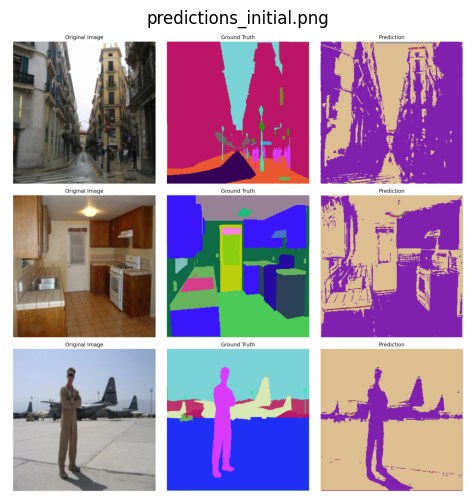

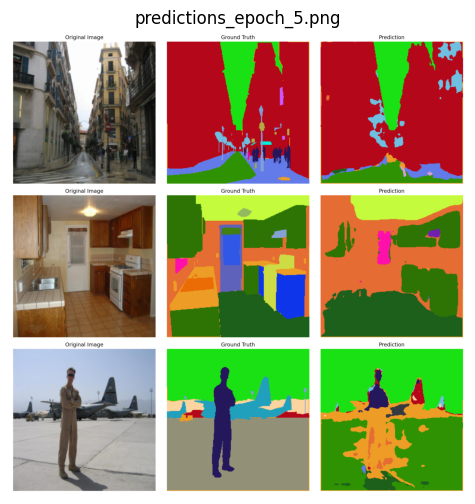

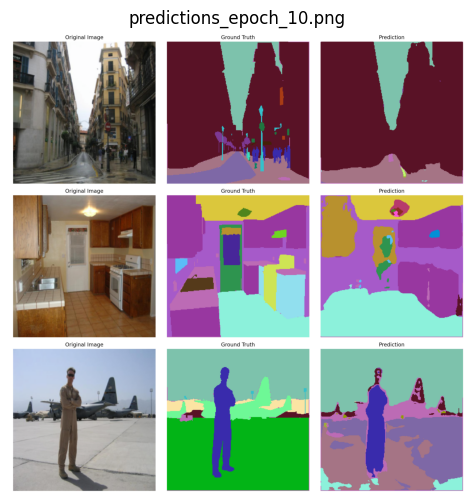

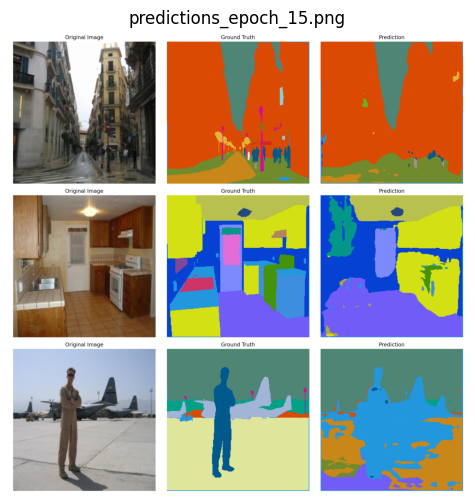

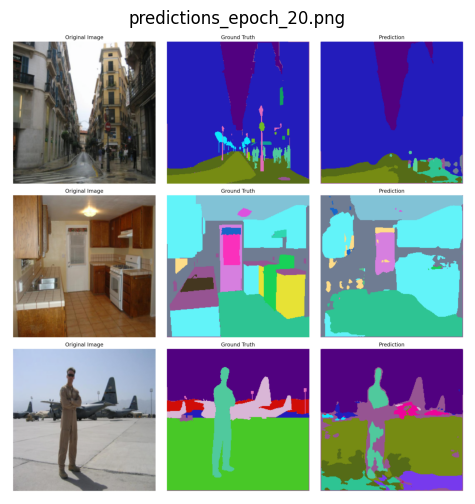

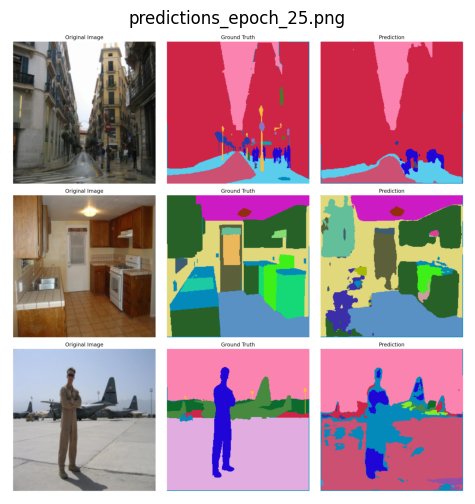

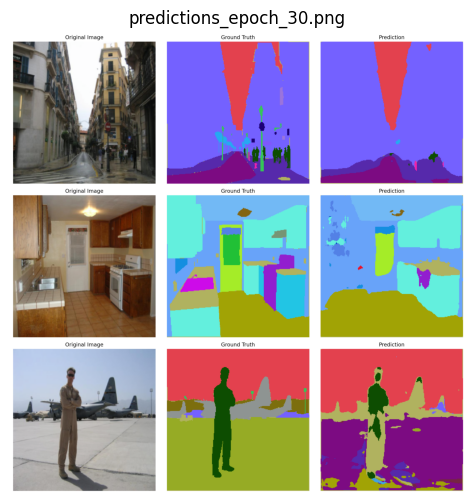

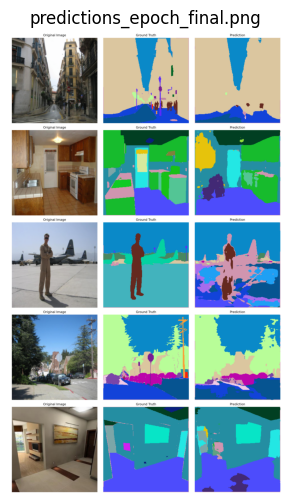

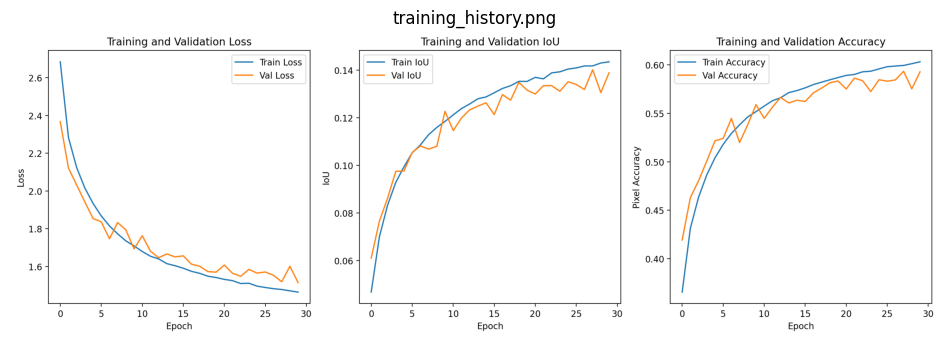

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plot_dir = '/kaggle/working/plots'

ordered_files = [
    'predictions_initial.png',
    'predictions_epoch_5.png',
    'predictions_epoch_10.png',
    'predictions_epoch_15.png',
    'predictions_epoch_20.png',
    'predictions_epoch_25.png',
    'predictions_epoch_30.png',
    'predictions_epoch_final.png',
    'training_history.png'
]

for file in ordered_files:
    img_path = os.path.join(plot_dir, file)
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
        plt.show()
    else:
        print(f"❌ File not found: {file}")
